In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import emcee
import exocartographer.gp_map as gm
import healpy
import plotutils.autocorr as ac
import plotutils.plotutils as pu
import seaborn

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
seaborn.set_style('ticks')

In [52]:
def credible_bounds(function_samples, cl=0.95):
    """
    Get the upper and lower credible boundaries of a 1-D function from a sample.
    """
    function_samples = np.atleast_2d(function_samples)
    N = function_samples.shape[0]

    sorted_samples = np.sort(function_samples, axis=0)
    low = sorted_samples[int((1-cl)/2.*N), :]
    high = sorted_samples[int((1+cl)/2.*N), :]
    return low, high

## Try Sampling From the Ylm GP

Here we have a map that has a 20% variance ($\sigma = 0.2$ in $\log$-space), only 1% white noise, with ``nside = 4``.  The angular scale is 
$$
\lambda = \frac{\pi}{2} = 90^\circ
$$

In [67]:
nside = 4
mu = 0.0
sigma = 0.2
wn_frac = 0.01
lam = np.pi/4

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


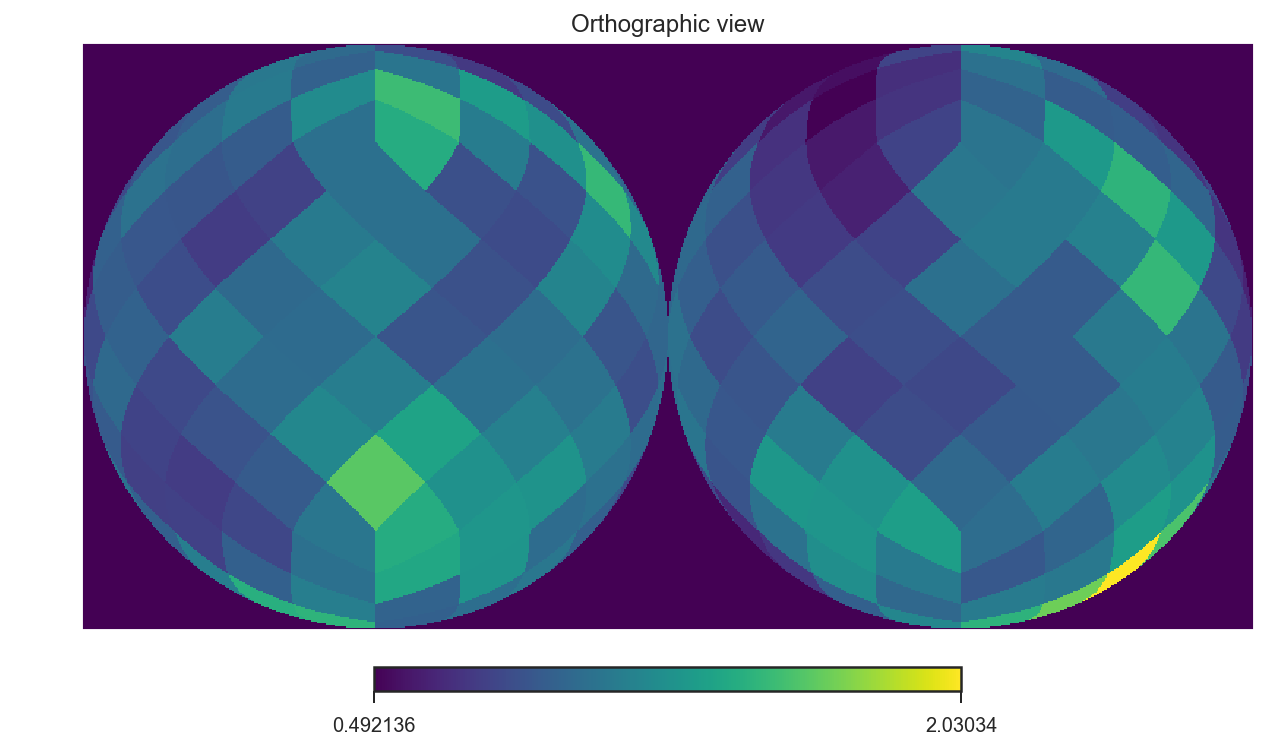

In [68]:
logmap = gm.draw_map_cl(nside, mu, sigma, wn_frac, lam)
healpy.orthview(exp(logmap), cmap='viridis')

Let's try to sample from this map prior; if we successfully do so, each draw will correspond to a map like the above.  

In [69]:
def logpost(logmap):
    return gm.map_logprior_cl(logmap, mu, sigma, wn_frac, lam)

In [70]:
nwalkers = 512
sampler = emcee.EnsembleSampler(nwalkers, healpy.nside2npix(nside), logpost)

Initial condition (cleverly drawn from the prior, so we don't have any burnin):

In [71]:
result = [array([gm.draw_map_cl(nside, mu, sigma, wn_frac, lam) for i in range(nwalkers)])]

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

I just keep running the cells below until I see good ACL estimates for each map pixel.  Usually I run for 1000, 2000, 4000, ... steps until I get there just so I don't have to re-start the runs all the time.

In [72]:
result = sampler.run_mcmc(result[0], 1000, thin=10)

0.1006796875


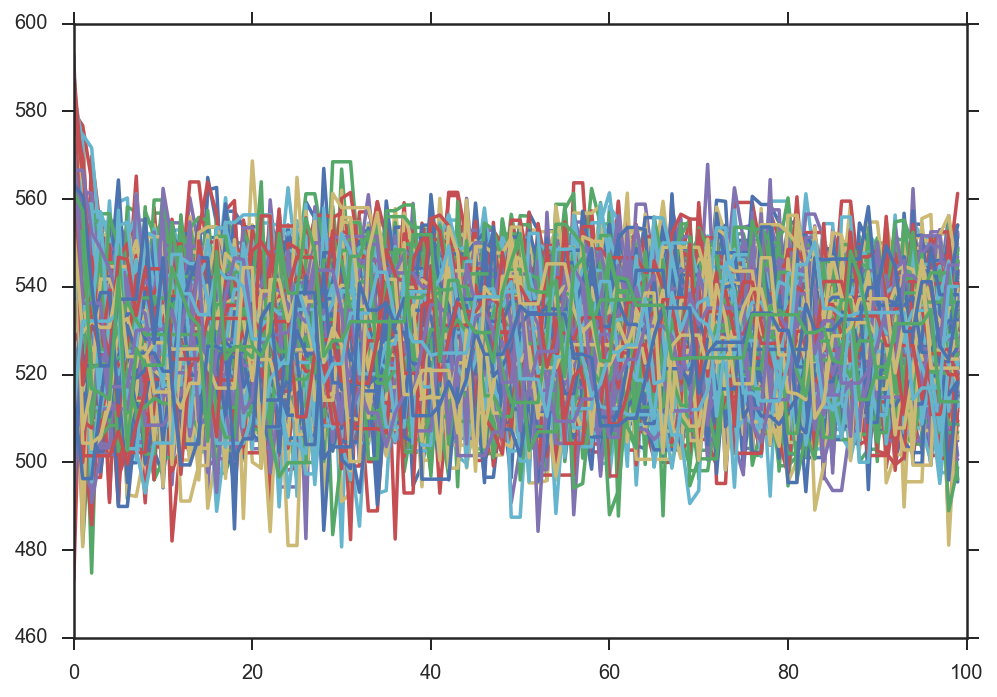

In [73]:
plot(sampler.lnprobability.T)
print mean(sampler.acceptance_fraction)

In [74]:
sampler.chain.shape

(512, 100, 192)

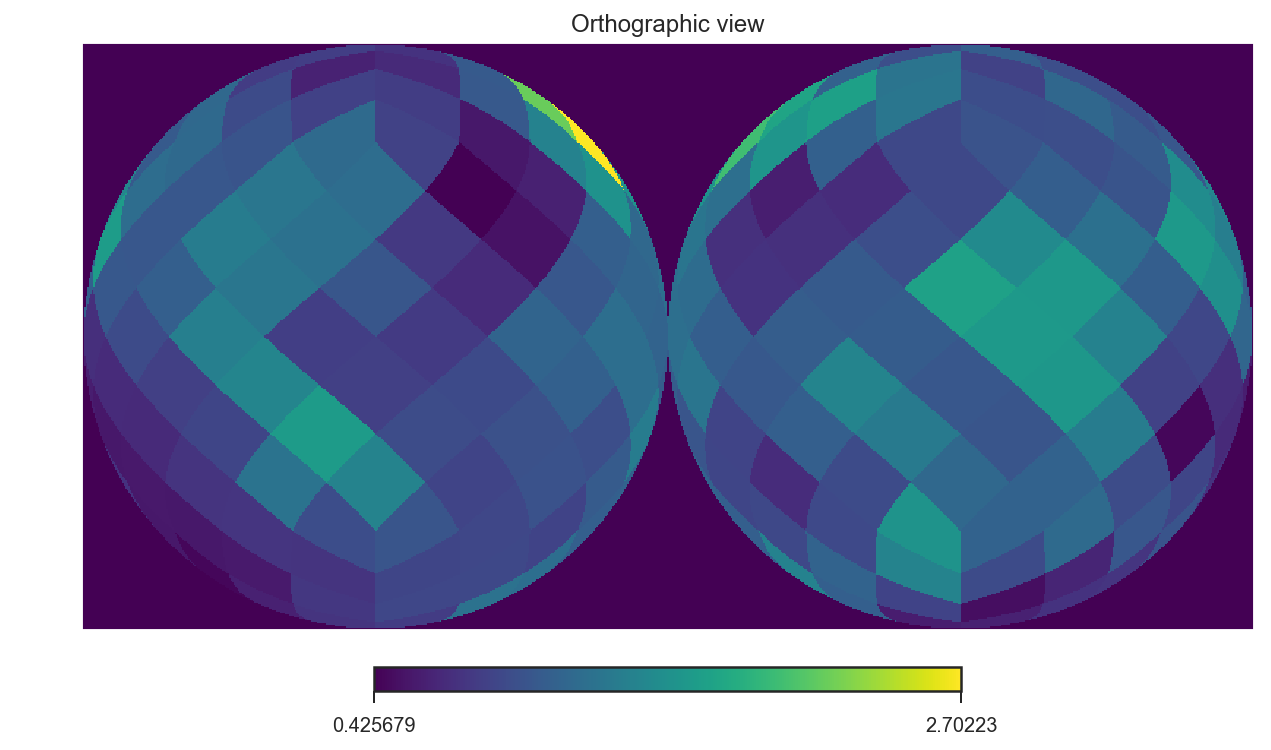

In [75]:
healpy.orthview(exp(sampler.chain[432, 10, :]), cmap='viridis')

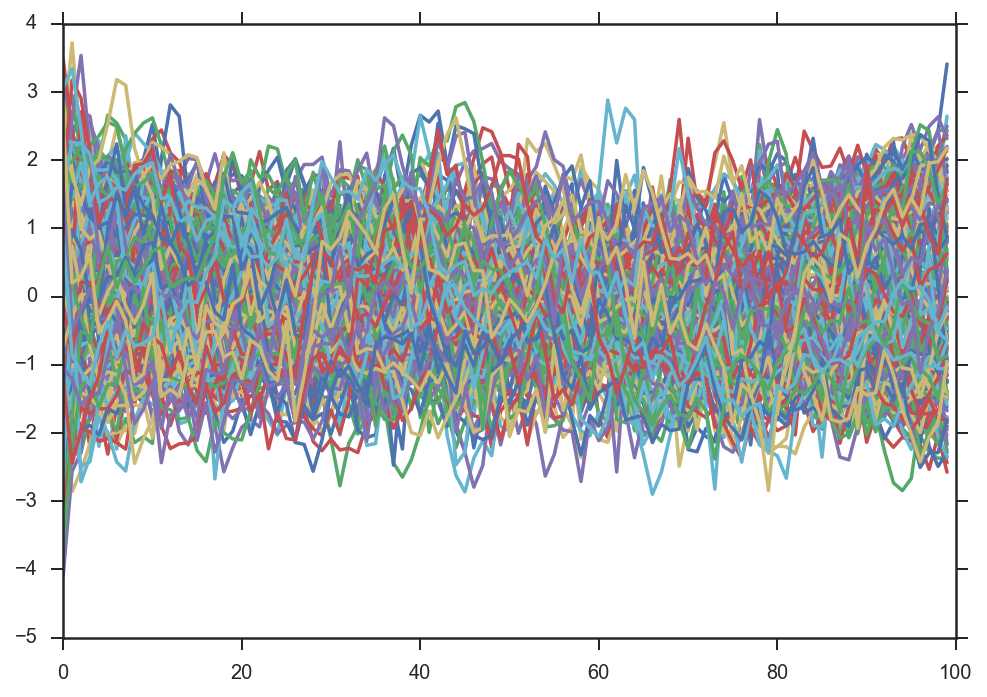

In [76]:
pu.plot_emcee_chains_one_fig(sampler.chain)

In [77]:
ac.emcee_chain_autocorrelation_lengths(sampler.chain)

array([        nan,         nan,         nan,         nan,  6.37138563,
               nan,         nan,         nan,  4.49913933,         nan,
        5.84584374,         nan,         nan,  7.30151683,         nan,
               nan,  6.86400056,  5.91389587,         nan,  6.02839943,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,  5.04617831,
        6.46144868,         nan,         nan,         nan,  4.63685822,
        5.92561505,         nan,         nan,         nan,         nan,
        6.7768717 ,         nan,         nan,         nan,  6.84063254,
        5.12517328,  4.11705327,  7.31796872,         nan,  7.01052464,
        4.11288168,  7.71249542,  6.16082274,         nan,         nan,
               nan,         nan,         nan,  6.44429005,         nan,
        4.33585962,  4.9949138 ,  7.60017787,         nan,  5.48975739,
        4.12369055,  3.02998532,         nan,         nan,  2.11

Let's check the mean angular power spectrum of the resulting maps.  This looks promising:

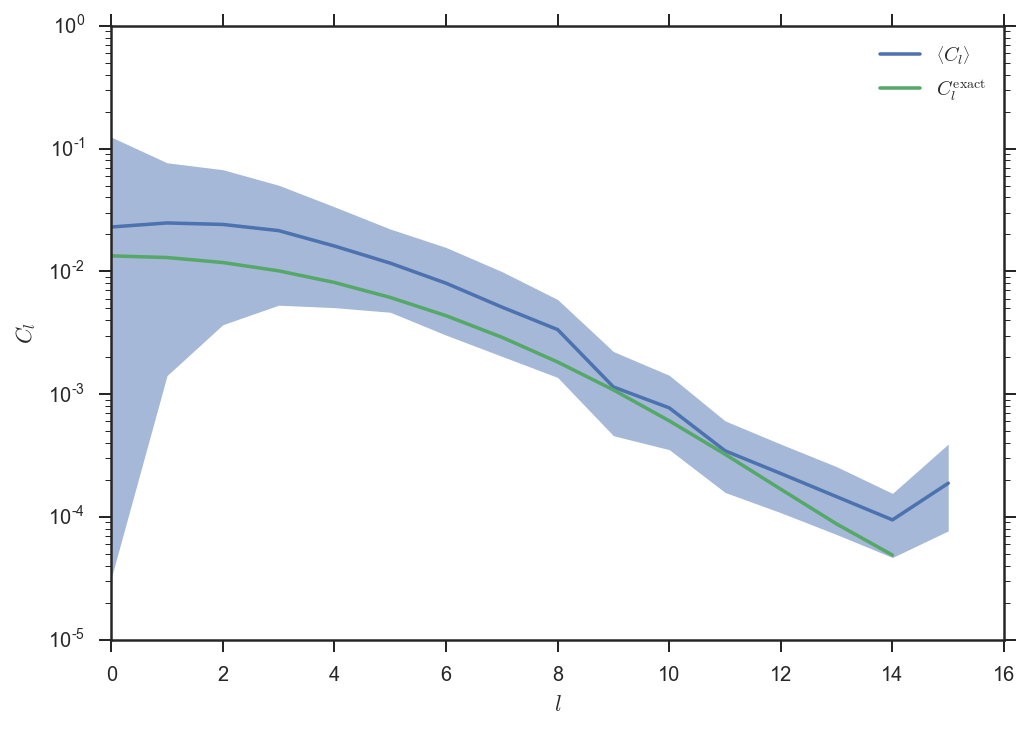

In [78]:
mean_cl = mean(array([healpy.anafast(r, lmax=4*nside-1) for r in result[0]]), axis=0)
lower_cl, upper_cl = credible_bounds(array([healpy.anafast(r, lmax=4*nside-1) for r in result[0]]))

fill_between(np.arange(len(mean_cl)), lower_cl, upper_cl, lw=0., alpha=0.5)
plot(mean_cl, label=r'$\left\langle C_l \right\rangle$')
plot(sigma*sigma*gm.exp_cov_cl(nside, wn_frac, lam), label=r'$C_l^\mathrm{exact}$')
yscale('log')
legend(loc='upper right')
xlabel(r'$l$')
ylabel(r'$C_l$')

...but this does not.  Since the Ylm's are not orthonormal, we have degenerate modes that we do not constrain with the prior:

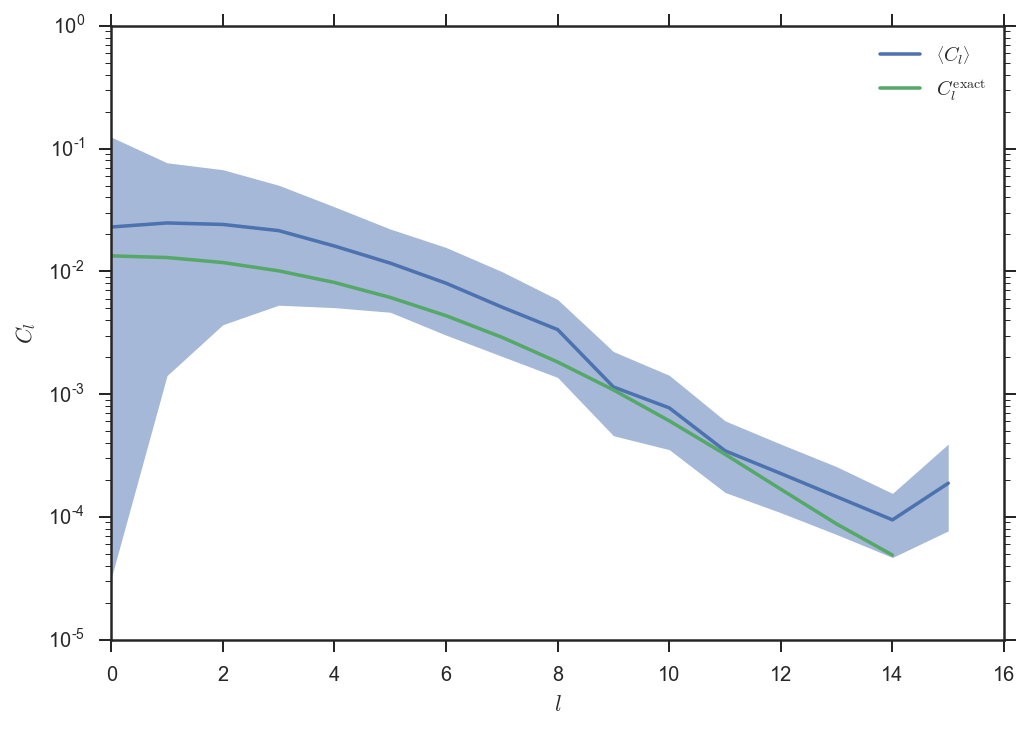

In [79]:
mean_cl = mean(array([healpy.anafast(r, lmax=4*nside-1) for r in result[0]]), axis=0)
lower_cl, upper_cl = credible_bounds(array([healpy.anafast(r, lmax=4*nside-1) for r in result[0]]))

fill_between(np.arange(len(mean_cl)), lower_cl, upper_cl, lw=0., alpha=0.5)
plot(mean_cl, label=r'$\left\langle C_l \right\rangle$')
plot(sigma*sigma*gm.exp_cov_cl(nside, wn_frac, lam), label=r'$C_l^\mathrm{exact}$')
yscale('log')
legend(loc='upper right')
xlabel(r'$l$')
ylabel(r'$C_l$')